# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
I plan to analyze the change of concepts and topic in philosophical texts and the social game lying behind them. My hypothesis is that the philosophical discussion in different eras has systematically differences and the texts in the same eras have some shared similarity. This kind of differences include writing styles, conceptual meanings and social implications. Therefore, I will analyze famous philosophers's texts.

## ***Why?***
Traditional philosophical research mainly focuses on qualitative study of philosophical texts and most studies only foucs on a very limited number of books since philosophical books are very difficult to read. If we can use computational method to analyze philosophical texts, we may have a much broader range and a new perspective to understand philosophical text. Besides, instead of reading obscure philosophical texts, the visualization of philosophical topics and contents might provide a more clear and overall development path of the history of philosophy and help us to understand concrete books. Finally, we may use some methods, such as word embedding, to understand the social implication behind many philosophers. This might provde us a new perspective to analyze the texts.

## ***How?***
I will select some representative philosophers in different eras and use their philosophical texts for analysis. Specifically, I will analyze the concepts they frequenctly use through word frequency analysis, explore their general similarity and difference by cluster analysis, and also look for the social game behind them through word embedding. If possible, I can also study the relationship between philosophers by network analysis and compare the results with the traditional idea. For the word frequency analysis, I can explore the superficial conceptual relationship among different philosophers. For cluster analysis and network analysis, it is possible for me to look at the general relationship among different philosophers. And for word embedding, I may dig out the different social contexts when two philosophers use the same concept. Generally, in this study, I can explore the differences and similairties among philosophers in different ears and also might trace the change of philosophical theory.  

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
I only select famous philosophers because of the discipline attributes. In other words, in philosophy, we typically only focus on the books that have big names. Therefore, famous philosophers have nearly represented the whole development of this discipline. The main social game I'm planning to make inferences are philosophers' discussion will influeced by the idea and social context in the eras. The virtues and limitations in my sample are the same thing: I only use famous philosophers' texts. Since philosophers' ideas are often ahead of their time, it cannot completely reflect the society at that time. However, I believe that they are still limited by their own era so that most philosophers can only be slightly ahead of their time instead of throw away the time.  

The words I will use including 2 categories. The first category contains some important concepts in the history of philosophy such as moral/morality, ethics, virtue, human, etc. The second category contains words related to social meaning such as male, female, etc.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

In [3]:
import os
import re

targetDir = '../Plato'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Plato = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Plato'})

targetDir = '../Aristotle'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Aristotle = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Aristotle'})



targetDir = '../Kant'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Kant = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Kant'})


targetDir = '../Hegel'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Hegel = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Hegel'})


targetDir = '../Nietzsche'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Nietzsche = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Nietzsche'})


corpora_df = pandas.concat([Aristotle, Kant, Nietzsche, Plato, Hegel])
corpora_no_remove = pandas.concat([Aristotle, Kant, Nietzsche, Plato, Hegel])

# Remove some features vectors 
remove = np.array(['replied', 'Crito', 'Cleinias', 'Timaeus', 'Protagoras', 'Theaetetus', r'\[\d+\]',
                   'Phaedrus', 'Phaedo', 'SOCRATES', 'Socrates', 'Philebus', 'Parmenides',r'\(\d+\)',
                   'Euthyphro', 'Meno', 'Nicias', 'Polus', 'Cratylus', 'Theodorus', 'Menexenus', 
                   'Nicias', 'Ion', 'Dion', 'Simmias', 'Agathon', 'Hellenes', 'Gorgias', '\n', '\t'
                   'theodorus', 'DIALOGUE', 'Athens', 'Athenian', 'Author', 'Athenians', 'THEODORUS',])
       
for i in range(corpora_df.shape[0]):
    for j in range(len(remove)):
        corpora_df["text"].iloc[i] = re.sub(remove[j], ' ', corpora_df["text"].iloc[i])

In [4]:
corpora_df[::10]

,author,book,text
0,Aristotle,Aristotle_Category.txt,The Categories By Aristotle Section 1 Pa...
10,Aristotle,Heavens.txt,Aristotle - On the Heavens Book I 1 The scien...
20,Aristotle,On Sophistical Refutations.txt,Aristotle - On Sophistical Refutations 1 Let ...
30,Aristotle,Politics.txt,Title: Politics A Treatise on Governmen...
2,Kant,Kant_Judgement.txt,1790 ...
12,Kant,persp-model_W18-master (1).zip,PK      ÝKEL             \t persp-model_W18...
1,Nietzsche,Birth_of_Tragedy.txt,ï»¿FRIEDRICH NIETZSCHE THE BIRTH OF TRAGEDY ...
11,Nietzsche,The Gay Science.txt,The Gay Science I This hook might need more t...
1,Plato,Plato_Charmides.txt,"Charmidest SCENE: The Palaestra of Taureas, wh..."
11,Plato,Plato_Lysis.txt,"Lysis, or Friendship PERSONS OF THE : , who ..."


In [5]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
corpora_df['tokenized_sents'] = corpora_df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
corpora_df['normalized_sents'] = corpora_df['tokenized_sents'].apply(lambda x: 
                                                                 [lucem_illud.normalizeTokens(s, stopwordLst = 
                                                                                              lucem_illud.stop_words_basic,
                                                                                              stemmer = None)
                                                                  for s in x])

F:\python\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
corporaVects = ngCountVectorizer.fit_transform(corpora_df['text'])
ngCountVectorizer.vocabulary_.get('vector')
corporaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(corporaVects)
corporaTF = corporaTFTransformer.transform(corporaVects)
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
corporaTFVects = ngTFVectorizer.fit_transform(corpora_df['text'])
corporaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(corporaVects)
  
numClusters = 8
km_remove = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km_remove.fit(corporaTFVects)
corpora_df['kmeans_predictions'] = km_remove.labels_
terms_remove = ngTFVectorizer.get_feature_names()
order_centroids = km_remove.cluster_centers_.argsort()[:, ::-1]
corpora_df[::10]

,author,book,text,tokenized_sents,normalized_sents,kmeans_predictions
0,Aristotle,Aristotle_Category.txt,The Categories By Aristotle Section 1 Pa...,"[[The, Categories, By, Aristotle, Section, 1, ...","[[categories, aristotle, section, part, things...",6
10,Aristotle,Heavens.txt,Aristotle - On the Heavens Book I 1 The scien...,"[[Aristotle, -, On, the, Heavens, Book, I, 1, ...","[[aristotle, heavens, book, science, nature, c...",4
20,Aristotle,On Sophistical Refutations.txt,Aristotle - On Sophistical Refutations 1 Let ...,"[[Aristotle, -, On, Sophistical, Refutations, ...","[[aristotle, sophistical, refutations, let, us...",6
30,Aristotle,Politics.txt,Title: Politics A Treatise on Governmen...,"[[Title, :, Politics, A, Treatise, on, Governm...","[[title, politics, treatise, government, treat...",7
2,Kant,Kant_Judgement.txt,1790 ...,"[[1790, THE, CRITIQUE, OF, JUDGEMENT, by, Imma...","[[critique, judgement, immanuel, kant, transla...",3
12,Kant,persp-model_W18-master (1).zip,PK      ÝKEL             \t persp-model_W18...,"[[PK,      ÝKEL             ,  persp-model_...","[[], [ð, ÿbe, pz, ê, q, iý, p, õ], [ràâ, ç, ç,...",0
1,Nietzsche,Birth_of_Tragedy.txt,ï»¿FRIEDRICH NIETZSCHE THE BIRTH OF TRAGEDY ...,"[[ï, », ¿FRIEDRICH, NIETZSCHE, THE, BIRTH, OF,...","[[ï, nietzsche, birth, tragedy, attempt], [], ...",5
11,Nietzsche,The Gay Science.txt,The Gay Science I This hook might need more t...,"[[The, Gay, Science, I, This, hook, might, nee...","[[gay, science, hook, might, need, one, prefac...",5
1,Plato,Plato_Charmides.txt,"Charmidest SCENE: The Palaestra of Taureas, wh...","[[Charmidest, SCENE, :, The, Palaestra, of, Ta...","[[charmidest, scene, palaestra, taureas, near,...",2
11,Plato,Plato_Lysis.txt,"Lysis, or Friendship PERSONS OF THE : , who ...","[[Lysis, ,, or, Friendship, PERSONS, OF, THE, ...","[[lysis, friendship, persons, narrator, hippot...",2


I first use flat modeling to initially explore dividng the corpus. Every cluster would have some words. I will use professional knowledge to decide which words are important and further look at their conditional frequency in every philosopher's books. Actually I don't think philosophical texts can be subsampled completely by computational methods.

## <span style="color:red">*Excercise 2*</span>
<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page. With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [7]:
x = np.loadtxt("../survey.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [8]:
anno.annotations

array([[0, 1, 0, 0],
       [1, 1, 2, 2],
       [0, 0, 0, 0],
       [0, 0, 1, 1],
       [3, 2, 2, 2],
       [0, 1, 1, 1],
       [0, 1, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 2, 1],
       [0, 0, 0, 1],
       [0, 1, 2, 1],
       [0, 1, 1, 0],
       [0, 1, 2, 1],
       [0, 0, 0, 1],
       [0, 2, 0, 0],
       [1, 0, 1, 2],
       [2, 0, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 3, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 2],
       [0, 2, 0, 1],
       [0, 1, 2, 1],
       [0, 0, 0, 0],
       [1, 1, 0, 1],
       [0, 0, 2, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 2],
       [0, 1, 1, 0],
       [3, 2, 2, 2]])

In [9]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [10]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.43939394, 0.39393939, 0.14393939, 0.02272727])

[[8. 8. 2. 0.]
 [5. 7. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 2. 0.]]


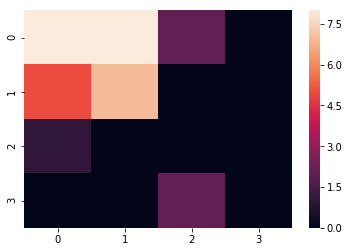

In [11]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [12]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.07692307692307696

In [13]:
fleiss_kappa(anno.annotations[::])

0.15892954669579476

In [14]:
krippendorffs_alpha(anno.annotations[::])

0.2994652406417111

In [15]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.09035222052067382

In [16]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.09035222 0.15263909 0.0952381 ]
 [0.09035222 1.         0.30477528 0.26229508]
 [0.15263909 0.30477528 1.         0.09836066]
 [0.0952381  0.26229508 0.09836066 1.        ]]


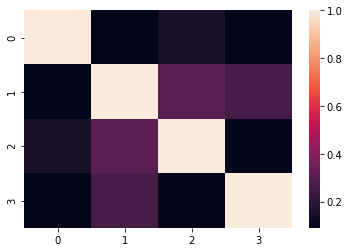

In [17]:
ax = seaborn.heatmap(m)
plt.show()

In [18]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.16727673689685144

In [19]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.16000000000000003

In [20]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.21949366075063334

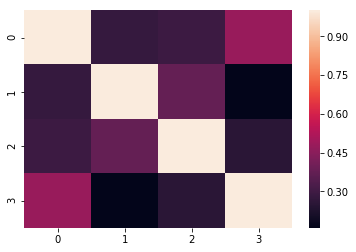

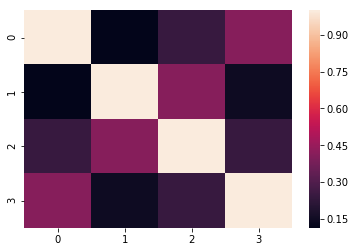

In [21]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [22]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.3071634799014643 0.26269795330154166


I select some extracts from philosophers' books and let people identify the attitudes toward gender. Actually, I find the results (almost all scores) are not as well as espected. I this there are two reasons. First, I don't have a large sample size in the survey due to the time limitation. With the increase of the sample size, the results might be better. Second and most importantly, philosophical books are difficult to understand and people may have big divergence on the same or similar contents. In this case, their choice would be diverse. For this reason, even human-coding can be problematic since some texts should be identified by professionals.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

In [23]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.65761723 0.28777799 0.03835717 0.01624761]
  [0.27469296 0.44278202 0.17965235 0.10287267]
  [0.10232762 0.16853397 0.4903551  0.23878331]
  [0.0453635  0.04021375 0.30267696 0.6117458 ]]

 [[0.73673011 0.20191293 0.04937546 0.01198149]
  [0.13389314 0.63401852 0.18472468 0.04736365]
  [0.03738604 0.0265228  0.75839275 0.17769841]
  [0.01247406 0.03448749 0.14985696 0.80318149]]

 [[0.57411756 0.3379823  0.0749374  0.01296275]
  [0.10866916 0.63005804 0.21462886 0.04664394]
  [0.10730581 0.0816728  0.55889772 0.25212367]
  [0.03528631 0.08942558 0.17886836 0.69641975]]

 [[0.72485981 0.15680927 0.04070084 0.07763008]
  [0.1294319  0.51206368 0.21676852 0.1417359 ]
  [0.0336702  0.11104588 0.6034946  0.25178933]
  [0.12088312 0.11934182 0.04047459 0.71930046]]]
-183.2634526860381


In [24]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 31, burn_in_samples=31, thin_samples=3)

In [25]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.56229988e-001 1.91734546e-001 5.20354663e-002 3.34595383e-053]
  [2.36326888e-001 6.47457392e-001 8.75760235e-002 2.86396960e-002]
  [4.19237852e-002 1.28621166e-001 6.22506271e-001 2.06948778e-001]
  [8.07890215e-317 5.26315789e-002 1.57894737e-001 7.89473684e-001]]

 [[7.44822239e-001 1.76412514e-001 7.87652474e-002 0.00000000e+000]
  [1.34941009e-001 7.48176040e-001 8.86025903e-002 2.82803607e-002]
  [4.20015396e-002 1.28556513e-001 7.04956333e-001 1.24485614e-001]
  [2.55259214e-317 5.26315789e-002 1.57894737e-001 7.89473684e-001]]

 [[7.72407159e-001 1.65039125e-001 6.25537155e-002 2.74841780e-038]
  [1.34894493e-001 5.92764013e-001 2.15841233e-001 5.65002614e-002]
  [4.17390926e-002 1.24863239e-001 7.08823343e-001 1.24574326e-001]
  [0.00000000e+000 5.26315789e-002 1.57894737e-001 7.89473684e-001]]

 [[6.52090758e-001 2.61269514e-001 8.66397287e-002 0.00000000e+000]
  [1.46237992e-001 6.91050572e-001 1.34431075e-001 2.82803607e-002]
  [4.15451022e-002 1.25205514e-001 7.08763

F:\python\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


In [26]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

In [27]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[9.61951369e-01 3.80326197e-02 1.60116493e-05 0.00000000e+00]
 [1.54264138e-02 9.00914284e-01 8.36593018e-02 6.46468628e-31]
 [9.98312601e-01 1.68611266e-03 1.28587095e-06 0.00000000e+00]
 [7.09316785e-01 2.90587000e-01 9.62154845e-05 0.00000000e+00]
 [1.61803948e-54 6.35305503e-03 9.93646945e-01 3.91614964e-29]
 [9.44129949e-02 9.05421509e-01 1.65496430e-04 0.00000000e+00]
 [6.81927141e-01 3.17987481e-01 8.53775843e-05 0.00000000e+00]
 [7.26980445e-01 2.72860916e-01 1.58639017e-04 0.00000000e+00]
 [9.91362311e-03 9.86936947e-01 3.14942999e-03 4.59221248e-32]
 [9.80459759e-01 1.95307415e-02 9.49912360e-06 0.00000000e+00]
 [9.76624858e-02 8.99773492e-01 2.56402259e-03 0.00000000e+00]
 [5.51467176e-01 4.48404309e-01 1.28514932e-04 0.00000000e+00]
 [9.76624858e-02 8.99773492e-01 2.56402259e-03 0.00000000e+00]
 [9.80459759e-01 1.95307415e-02 9.49912360e-06 0.00000000e+00]
 [9.89421922e-01 1.03758103e-02 2.02268084e-04 0.00000000e+00]
 [2.75871021e-01 7.16399219e-01 7.72975988e-03 0.000000

In [28]:
def makeQuestionComparison(model, anno_target, num_questions = 10):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x1b91da41470>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1b91d3b3748>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1b91d456470>))

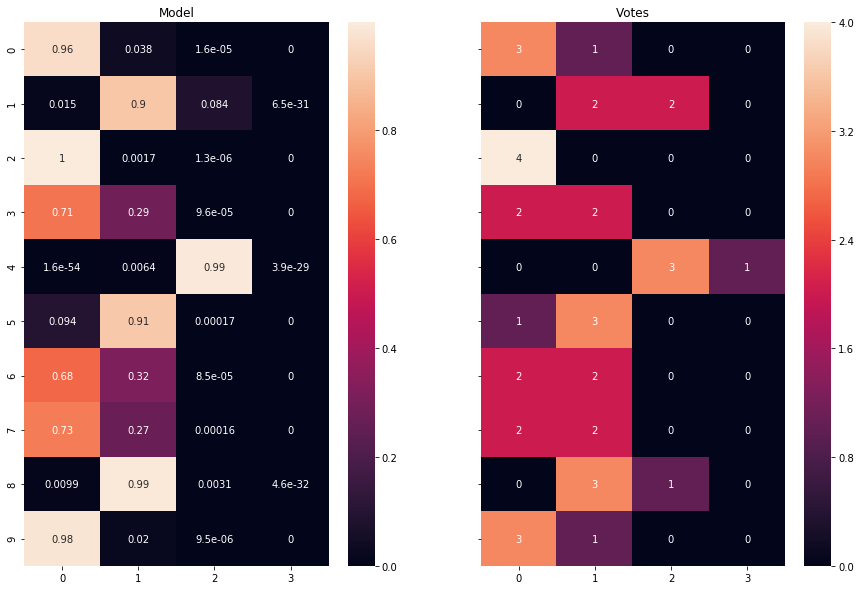

In [29]:
makeQuestionComparison(model, anno)

In [30]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 4)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.64602355 0.79650157 0.73817929 0.60783758]
-185.3398820095177


In [31]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.60462434 0.82136056 0.64709912 0.64376344]
-151.08002758033481


In [32]:
model.sample_posterior_over_accuracy(anno.annotations, 31, burn_in_samples=31, thin_samples=3)

array([[0.67146771, 0.61574391, 0.51371782, 0.64278098],
       [0.79844352, 0.57031116, 0.59440588, 0.66651688],
       [0.74938451, 0.66320956, 0.59913602, 0.63592997],
       [0.74938451, 0.66320956, 0.59913602, 0.63592997],
       [0.61240017, 0.67581616, 0.68918383, 0.58396614],
       [0.63527554, 0.65272098, 0.74998733, 0.67304797],
       [0.74579711, 0.63239069, 0.75844543, 0.5474079 ],
       [0.74579711, 0.63239069, 0.75844543, 0.5474079 ],
       [0.74579711, 0.63239069, 0.75844543, 0.5474079 ],
       [0.57735602, 0.7417658 , 0.62207334, 0.51386822],
       [0.6385339 , 0.82685267, 0.7812889 , 0.6054441 ],
       [0.6385339 , 0.82685267, 0.7812889 , 0.6054441 ],
       [0.6385339 , 0.82685267, 0.7812889 , 0.6054441 ],
       [0.67945226, 0.86582403, 0.6572238 , 0.65400287],
       [0.7178699 , 0.87950731, 0.67668709, 0.60410891],
       [0.71137895, 0.72951327, 0.61480446, 0.5365819 ],
       [0.71137895, 0.72951327, 0.61480446, 0.5365819 ],
       [0.69162665, 0.67244379,

In [33]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[9.46717799e-01 5.22447324e-02 1.03746685e-03 2.24757306e-09]
 [2.49312172e-02 8.63590322e-01 1.11478452e-01 8.09808103e-09]
 [9.99630644e-01 2.89938575e-04 7.94173667e-05 1.72050157e-10]
 [7.93439344e-01 2.04680738e-01 1.87991432e-03 4.07265522e-09]
 [1.58166128e-02 8.65771021e-03 9.75525653e-01 2.35694298e-08]
 [1.99543890e-02 9.79393470e-01 6.52139523e-04 1.41279813e-09]
 [3.80531845e-01 6.17207394e-01 2.26075638e-03 4.89771326e-09]
 [8.42647633e-01 1.55662864e-01 1.68950006e-03 3.66014089e-09]
 [5.27383970e-03 9.90376399e-01 4.34976003e-03 1.71303233e-09]
 [9.91123971e-01 8.44914115e-03 4.26887045e-04 9.24810101e-10]
 [9.89889866e-02 8.83214765e-01 1.77962417e-02 7.00855613e-09]
 [3.73696637e-01 6.24050612e-01 2.25274588e-03 4.88035927e-09]
 [9.89889866e-02 8.83214765e-01 1.77962417e-02 7.00855613e-09]
 [9.91123971e-01 8.44914115e-03 4.26887045e-04 9.24810101e-10]
 [9.81242000e-01 3.92572914e-03 1.48322685e-02 2.32953588e-09]
 [4.85337333e-01 4.86062127e-01 2.86005282e-02 1.142890

(<matplotlib.figure.Figure at 0x1b91d3a6e80>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1b91d678898>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1b91d4e1320>))

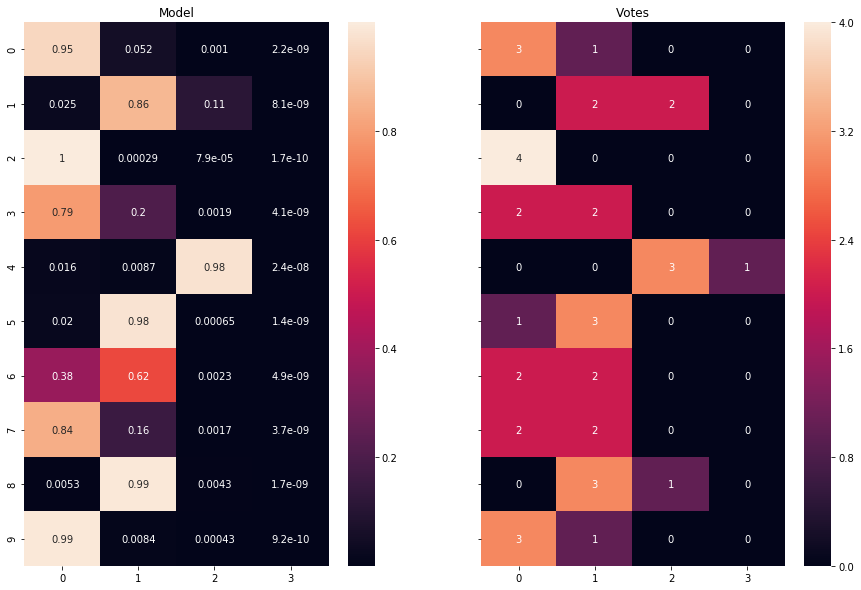

In [34]:
makeQuestionComparison(model, anno)

In [35]:
model = ModelBt.create_initial_state(4,4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

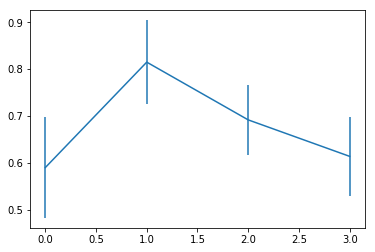

In [36]:
plt.figure()
plt.errorbar(range(4),y, yerr = y_ci)
plt.show()

Actually, the general accurary, excluding myself(the second one) is not high (only around 0.6). Therefore, we need more professional people to code it.